Zachary Hill  
CSPB3202 Artificial Intelligence  
OpenAI Gym Project
GituHub: https://github.com/zhill9142/OpenAI-Taxi

## Introduction to the Taxi Problem
    For this project the goal will be to create an agent that can solve the reinforcement learning environments provided by OpenAI gymniasium. This writeup will use the taxi environement which is a toy problem provided by the gym. At the end of the project the agent should take actions that return the best score by getting the tax to the correct destinations with as high of a score as possible.

## The Environment
    The environments is the taxi toy provided by gymnasium in the toy problems section. The problem is a grid world setup where the taxi navigates the world dropping off passengers in four location. The goal is to move to a passenger location then move to the passenger's destination to drop them off. There are a few actions the taxi can take move in the four caridinal directions, pick up, or drop off a passenger. The states obsereved are base on the 25 taxi positions and 5 locations the passengers can be in and 4 destinations. Rewards are given for delivering a passenger to their destination and are worth 20 points. Points are taken away for each step taken and for executing a drop off or pickup when there are no passengers. The episode ends when the taxi drops off the passenger.

## Exploration
Starting off the goal is to have the agent take a completely random action to see how the program works at first.

In [1]:
import gymnasium as gym
import random
import numpy as np
from collections import defaultdict

In [2]:
taxiEnv = gym.make('Taxi-v3', render_mode='rgb_array')
print('Action Space {}'.format(taxiEnv.action_space))

Action Space Discrete(6)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [4]:
#function for output of an image
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

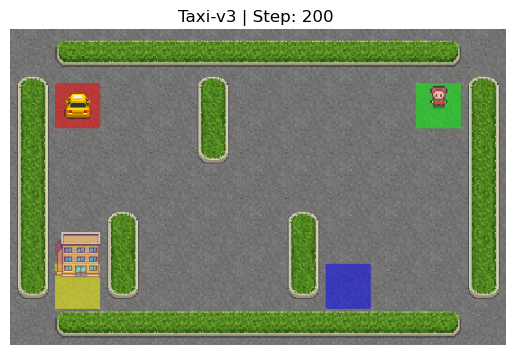

Episode done in 200 steps, total reward -776.00


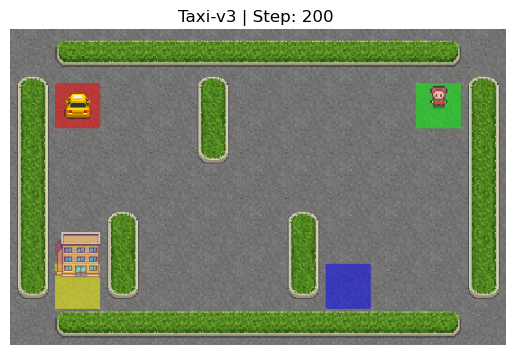

In [5]:
total_reward = 0.0
total_steps = 0
obs = taxiEnv.reset()

while True:
    action = taxiEnv.action_space.sample() #.sample method gives a random action sample
    obs, reward, done, _, _ = taxiEnv.step(action)
    total_reward += reward
    total_steps += 1
    show_state(taxiEnv,total_steps)
    if done or total_steps >=200:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

    With completely random actions it is unlikely for the taxi to reach the destination in a timely manner. It will basically always end by reaching the 200 step limit before it gets to the destination and give a poor reward.

## Q Learning Agent
    In order to have the taxi get to the passenger and drop them of in a timely manner it will learn to do so through Q-Learning. Below is the code needed to create the learning alrgorithm for this

In [6]:
#first we want the total amount of actions and observations available to create the initial q values
print(taxiEnv.action_space)
print(taxiEnv.observation_space)

Discrete(6)
Discrete(500)


    There are 6 possible actions and 500 possible states and by knowing that the initial qtable can be made with all values of 0

In [279]:
qTable = np.zeros((taxiEnv.observation_space.n, taxiEnv.action_space.n))

In [280]:
#fucntion for getting next action
def getAction(qTable, epsilon, state):
    #take a random action if random numbe less than epsilon
    if random.random() < epsilon:
        action = taxiEnv.action_space.sample()
    #otherwise take the action with the higest q value
    else:
        action = np.argmax(qTable[state])
    return action

#function for updating qTable
def updateQ(qTable, state, action, reward, nextState, alpha, discount):
    qCurrent = qTable[state][action]
    qNext = np.max(qTable[nextState])
    #update function
    qNew = (1-alpha) * qCurrent + alpha * (reward + discount * qNext)
    qTable[state][action] = qNew
    return qNew

    With the above functions the training episodes can start by setting up the hyperparameters and looping thorugh different episodes.

In [281]:
#hyperparameters
alpha = 0.5
discount = 1
epsilon = 1
episodes = 200

In [282]:
#Training
training_rewards = []

for trial in range(episodes):
    total_reward = 0.0
    total_steps = 0
    obs = taxiEnv.reset()
    #epsilon slowly decreases as the last trial is eached
    epsilon = (episodes - trial)/episodes
    #we just want the state after rest which is in the 0 position
    obs = obs[0]
    #loop for each trial
    while True:
        #get the action based on either random actions or max q
        action = getAction(qTable, epsilon, obs)
        nextObs, reward, done, _, _ = taxiEnv.step(action)
        total_reward += reward
        total_steps += 1
        updateQ(qTable, obs, action, reward, nextObs, alpha, discount)
        obs = nextObs
        if done or total_steps >=200:
            break
    training_rewards.append(total_reward)

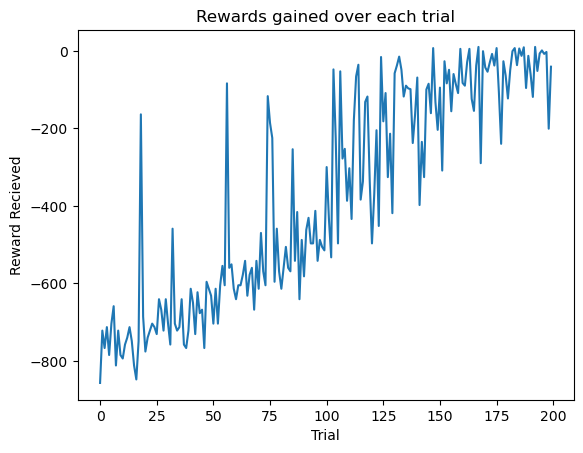

In [283]:
x = range(episodes)
plt.plot(x, training_rewards)
plt.xlabel('Trial')
plt.ylabel('Reward Recieved')
plt.title('Rewards gained over each trial') 
plt.show()

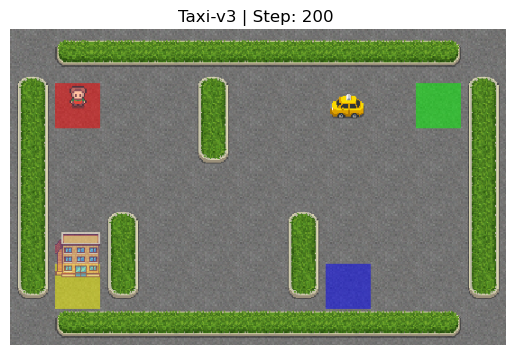

Episode done in 200 steps, total reward -200.00


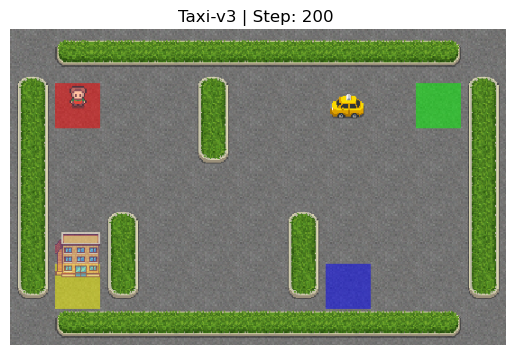

In [287]:
total_reward = 0.0
total_steps = 0
obs, _= taxiEnv.reset()

while True:
    action = getAction(qTable, 0, obs)
    obs, reward, done, _, _ = taxiEnv.step(action)
    total_reward += reward
    total_steps += 1
    show_state(taxiEnv,total_steps)
    if done or total_steps >=200:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

<img src="Gifs/first test.gif" align="center">

The above algorithm has come up with an interesting solution. Instead of trying to pick up passengers it goes back and forth forever or stays in the same spot avoiding losing points by failing to pick up pasengers. This will always give it a reward of -200 but it isn't really the intended goal of the project. So it will continue to be tweaked until some more intended behavior can happen.

In [140]:
qTable = np.zeros((taxiEnv.observation_space.n, taxiEnv.action_space.n))

In [141]:
#hyperparameters
alpha = 0.5
discount = 1
epsilon = 1
episodes = 500

In [142]:
#Training version 2
training_rewards = []
epsilons = []

for trial in range(episodes):
    total_reward = 0.0
    total_steps = 0
    obs = taxiEnv.reset()
    #epsilon slowly decreases as the last trial is eached
    epsilon = (episodes - trial)/episodes
    #we just want the state after rest which is in the 0 position
    obs = obs[0]
    #loop for each trial
    while True:
        #get the action based on either random actions or max q
        action = getAction(qTable, epsilon, obs)
        nextObs, reward, done, _, _ = taxiEnv.step(action)
        total_reward += reward
        total_steps += 1
        updateQ(qTable, obs, action, reward, nextObs, alpha, discount)
        obs = nextObs
        if done or total_steps >=200:
            break
    training_rewards.append(total_reward)
    epsilons.append(epsilon)

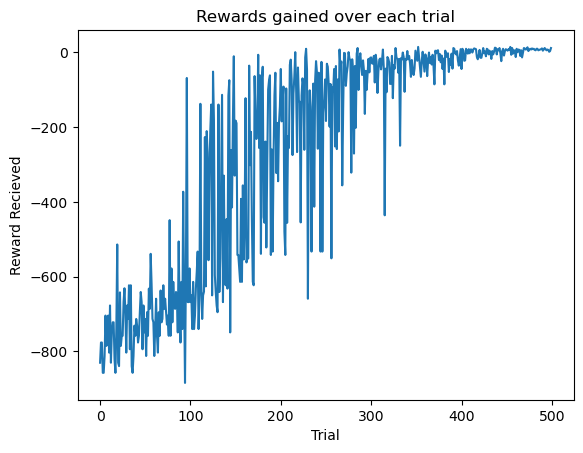

In [143]:
x = range(episodes)
plt.plot(x, training_rewards)
plt.xlabel('Trial')
plt.ylabel('Reward Recieved')
plt.title('Rewards gained over each trial') 
plt.show()

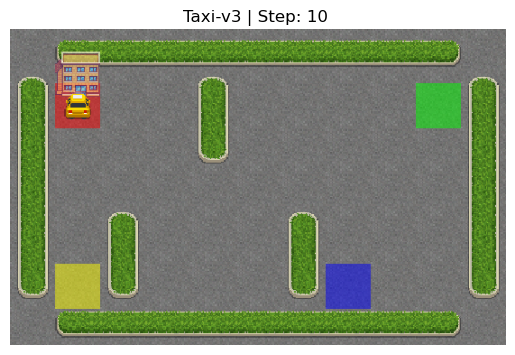

Episode done in 10 steps, total reward 11.00


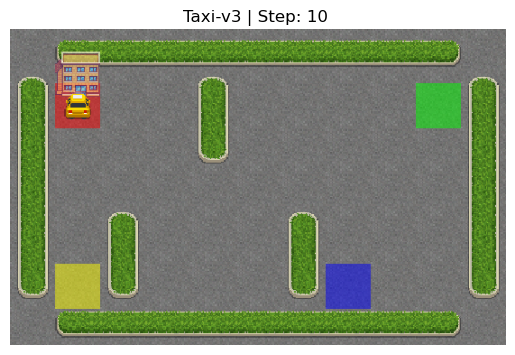

In [144]:
total_reward = 0.0
total_steps = 0
obs, _= taxiEnv.reset()

while True:
    action = getAction(qTable, 0, obs)
    obs, reward, done, _, _ = taxiEnv.step(action)
    total_reward += reward
    total_steps += 1
    show_state(taxiEnv,total_steps)
    if done or total_steps >=200:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

    It seems that the learnign agent was able to figure it out with just more testing trials. Increasing the number of episodes from 200 to 500 allowed it to find optimal solutions so it could complete the task. For the next part of the project the hyperparameters will be tuned more so it can get to a solution faster. Right now going below 450 episodes causes it to often get stuck where the taxi will stay still and not pick up passengers like the first trial.

## Tuning parameters
There are a few things to change and see if it improves how fast the agents learns.
- The current epsilon decay is lineaer and could probably be changed to something more gradual.
- Learning rate could be tuned to see which number returns the best results.
- There isn't a discount currently and that might mean the agent isn't prioritizing as much as it should

In [288]:
qTable = np.zeros((taxiEnv.observation_space.n, taxiEnv.action_space.n))

#hyperparameters
alpha = 0.7
discount = 0.8
epsilon = 1
episodes = 1800

#Training version 2
training_rewards = []
epsilons = []

for trial in range(episodes):
    total_reward = 0.0
    total_steps = 0
    obs = taxiEnv.reset()
    #epsilon slowly decreases as the last trial is eached
    epsilon = epsilon * 0.99
    #we just want the state after rest which is in the 0 position
    obs = obs[0]
    #loop for each trial
    while True:
        #get the action based on either random actions or max q
        action = getAction(qTable, epsilon, obs)
        nextObs, reward, done, _, _ = taxiEnv.step(action)
        total_reward += reward
        total_steps += 1
        updateQ(qTable, obs, action, reward, nextObs, alpha, discount)
        obs = nextObs
        if done or total_steps >=200:
            break
    training_rewards.append(total_reward)
    epsilons.append(epsilon)

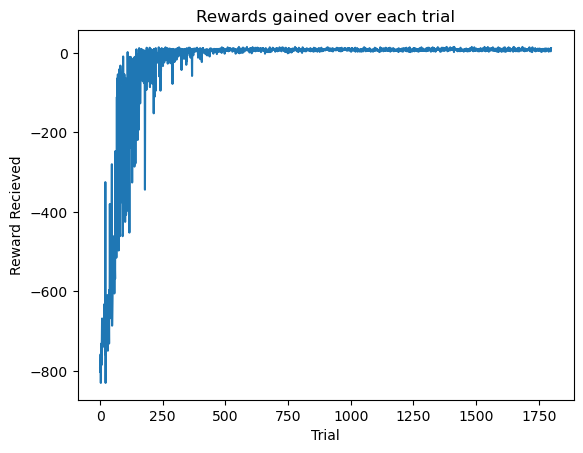

In [289]:
x = range(episodes)
plt.plot(x, training_rewards)
plt.xlabel('Trial')
plt.ylabel('Reward Recieved')
plt.title('Rewards gained over each trial') 
plt.show()

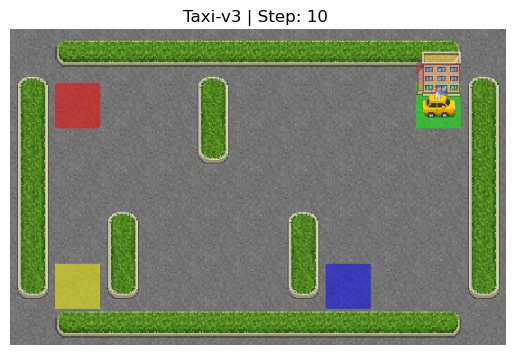

Episode done in 10 steps, total reward 11.00


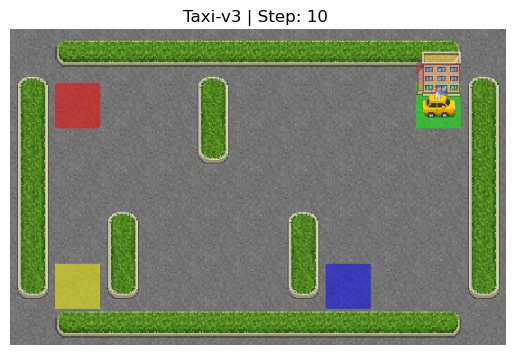

In [294]:
total_reward = 0.0
total_steps = 0
obs, _= taxiEnv.reset()

while True:
    action = getAction(qTable, 0, obs)
    obs, reward, done, _, _ = taxiEnv.step(action)
    total_reward += reward
    total_steps += 1
    show_state(taxiEnv,total_steps)
    if done or total_steps >=30:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))


<img src="Gifs/final test.gif" align="center">

    Working with some of the paramters it seems like the q learning algorithm started to work better getting to optimal results faster. Changing the linear epsilon decrease for an exponential one improved it a lot. The alpha was better at higher values and it settled on 0.7 instead of the 0.5 it started with. The discount rate was changed from 1 to 0.8, going really low on the values cause the taxi to get stuck more often so only a slight discount seems to work best. With these changes the algorithm would get good results in around 250 tests.

    Testing how often the learned algorithm succeeds gives the following

In [277]:
testCount = 1000
succeed = 0
for episode in range(testCount):
    total_reward = 0.0
    total_steps = 0
    obs, _= taxiEnv.reset()

    while True:
        action = getAction(qTable, 0, obs)
        obs, reward, done, _, _ = taxiEnv.step(action)
        total_reward += reward
        total_steps += 1
        if done or total_steps >=30:
            break
    #add a count if the taxi makes it to the end
    if(total_reward > 0):
        succeed += 1

print("Agent successfuly transports the passenger %.1f percent of the time" % ((succeed/testCount)*100))

Agent successfuly transports the passenger 100.0 percent of the time


    Although it starts to give good results at around 300 trails in order to get the agent to always work correctly the trials number has to be increased much higher to around 1800. At that count the taxi almost always succceds in making it to the goal.

## Conclusion
    Overall training an agent in the gym environments was intesteresting and helped me learn more about how Q-Learning agents fucntion building upon what was already discussed in class. I think the hardest part about coding these is figuring out how to store values in a q table for the problem. I originally wanted to do this for the bipedal walker environmentbut I couldn't figure out how to structure a table for holding q values so I switched to this to be simpler. For improvements I think I would want to try this with a more complicated environment, change some of the parameters some more, or use the same agent on a different problem.

### References
https://gymnasium.farama.org/environments/toy_text/taxi/ 